<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Embeddings

_Basic assumption: airlines fliying similar routes are similar_

## Data Sets
* Single Flights: http://stat-computing.org/dataexpo/2009/the-data.html
* Routes between airports: https://openflights.org/data.html#route

## Advanced examples
* autoencoders on tabular data: https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_tabular.ipynb
* robust training on additional data: https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_stabilize.ipynb

In [2]:
!pip install -q tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 346.6MB 41kB/s 
     |████████████████████████████████| 3.1MB 26.5MB/s 
     |████████████████████████████████| 430kB 40.6MB/s 
     |████████████████████████████████| 61kB 21.2MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190510


In [4]:
!curl -O https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2321k  100 2321k    0     0  3193k      0 --:--:-- --:--:-- --:--:-- 3193k


In [0]:
# pd.read_csv?

In [6]:
import pandas as pd

df = pd.read_csv('routes.dat', quotechar="'", sep=',', encoding='utf-8', header=None, na_values='\\N',
                names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

# https://openflights.org/data.html#route
  
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

# df[df['Stops'] == 1] gives only a dozen or so routes, so also drop it
df.drop(['Airline ID',	'Source airport ID', 'Destination airport ID', 'Codeshare', 'Equipment', 'Stops'], axis='columns', inplace=True)
len(df)

67663

In [7]:
df.head()

,Airline,Source airport,Destination airport
0,2B,AER,KZN
1,2B,ASF,KZN
2,2B,ASF,MRV
3,2B,CEK,KZN
4,2B,CEK,OVB


In [8]:
sources = df['Source airport'].unique()
len(sources)

3409

In [9]:
destinations = df['Destination airport'].unique()
len(destinations)

3418

In [10]:
airlines = df['Airline'].unique()
len(airlines)

568

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

airline_tokenizer = Tokenizer()
airline_tokenizer.fit_on_texts(df['Airline'])

import numpy as np

encoded_airlines = np.array(airline_tokenizer.texts_to_sequences(df['Airline'])).reshape(-1)
encoded_airlines

array([241, 241, 241, ..., 543, 543, 543])

In [12]:
len(encoded_airlines) 

67663

In [13]:
routes = df[['Source airport', 'Destination airport']].apply(lambda x: ' '.join(x), axis=1)
routes.head()

0    AER KZN
1    ASF KZN
2    ASF MRV
3    CEK KZN
4    CEK OVB
dtype: object

In [0]:
routes_tokenizer = Tokenizer()
routes_tokenizer.fit_on_texts(routes)
encoded_routes = np.array(routes_tokenizer.texts_to_sequences(routes))

In [15]:
# should be a bit more 3400 as source and destination are from the same set
output_dim = len(routes_tokenizer.word_index) + 1
output_dim

3426

In [16]:
encoded_routes[0]

array([511, 491])

In [17]:
len(encoded_routes)

67663

In [0]:
from tensorflow.keras.utils import to_categorical

# sequence of airlines encoded as a unique number
x = encoded_airlines
# sequence of pair, src, dest encoded as a unique numbers
Y = to_categorical(encoded_routes)
# for now just the source
# Y = to_categorical(encoded_routes[:, 0])

In [19]:
Y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 2d embeddings

In [20]:
%%time

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, RepeatVector
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.initializers import glorot_normal
seed = 3

input_dim = len(airlines) + 1
embedding_dim = 2

model = Sequential()

model.add(Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                    embeddings_initializer=glorot_normal(seed=seed)))

# https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras
# averages over all (global) embedding values 
# model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(RepeatVector(2))

model.add(SimpleRNN(units=50, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(Dense(units=output_dim, name='output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 2)              1138      
_________________________________________________________________
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 50)                150       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 50)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           174726    
Total params: 181,064
Trainable params: 181,064
Non-trainable params: 0
__________________________________________________

In [21]:
model.predict(np.array([x[0]])).shape

(1, 2, 3426)

In [22]:
Y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
%%time

EPOCHS=25
BATCH_SIZE=10

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/25
67663/67663 [==============================] - 80s 1ms/sample - loss: 6.1892 - accuracy: 0.0341
Epoch 2/25
67663/67663 [==============================] - 80s 1ms/sample - loss: 5.2574 - accuracy: 0.0845
Epoch 3/25
67663/67663 [==============================] - 80s 1ms/sample - loss: 4.9058 - accuracy: 0.1139
Epoch 4/25
67663/67663 [==============================] - 83s 1ms/sample - loss: 4.7229 - accuracy: 0.1265
Epoch 5/25
67663/67663 [==============================] - 80s 1ms/sample - loss: 4.6135 - accuracy: 0.1339
Epoch 6/25
67663/67663 [==============================] - 80s 1ms/sample - loss: 4.5381 - accuracy: 0.1395
Epoch 7/25
67663/67663 [==============================] - 81s 1ms/sample - loss: 4.4804 - accuracy: 0.1442
Epoch 8/25
67663/67663 [==============================] - 80s 1ms/sample - loss: 4.4368 - accuracy: 0.1460
Epoch 9/25
67663/67663 [==============================] - 86s 1ms/sample - loss: 4.4006 - accuracy: 0.1490
Epoch 10/25
67663/67663 [============

In [24]:
loss, accuracy = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss, accuracy

67663/67663 [==============================] - 42s 619us/sample - loss: 4.1447 - accuracy: 0.1614


(4.144686136489492, 0.16139545)

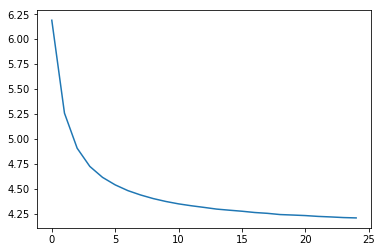

In [25]:
# plt.yscale('log')
plt.plot(history.history['loss'])

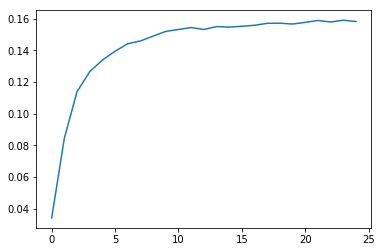

In [26]:
# plt.yscale('log')
plt.plot(history.history['accuracy'])

In [0]:
samples = pd.DataFrame(encoded_airlines).sample(n=200).values.reshape(-1)

In [0]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

europe_airlines = ['LH', 'BA', 'SK', 'KL', 'AF', 'FR', 'SU', 'EW', 'TP', 'BT', 'U2']
us_airlines = ['AA', 'US', 'UA', 'WN', 'DL', 'AS', 'HA']

In [0]:
samples = [airline_tokenizer.word_index[airline_code.lower()] for airline_code in europe_airlines + us_airlines]

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(samples).reshape(-1, 2)

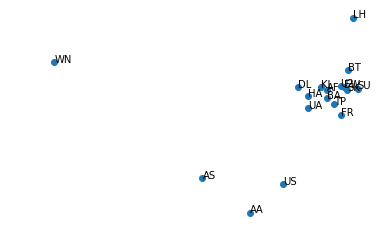

In [31]:
# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)

plt.axis('off')

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for index, x_pos, y_pos in zip(samples, embeddings_2d[:, 0], embeddings_2d[:, 1]):
  name = airline_tokenizer.index_word[index].upper()
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos))

## 1d embeddings

In [32]:
%%time

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, RepeatVector
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.initializers import glorot_normal
seed = 7

input_dim = len(airlines) + 1
embedding_dim = 1

model = Sequential()

model.add(Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                   embeddings_initializer=glorot_normal(seed=seed)))

# model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(RepeatVector(2))

model.add(SimpleRNN(units=50, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(Dense(units=output_dim, name='output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 1)              569       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           174726    
Total params: 180,445
Trainable params: 180,445
Non-trainable params: 0
________________________________________________

In [33]:
%%time

EPOCHS=20
BATCH_SIZE=10

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 6.3878 - accuracy: 0.0223
Epoch 2/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 5.7292 - accuracy: 0.0400
Epoch 3/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 5.4620 - accuracy: 0.0550
Epoch 4/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 5.3005 - accuracy: 0.0645
Epoch 5/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 5.1944 - accuracy: 0.0694
Epoch 6/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 5.1179 - accuracy: 0.0732
Epoch 7/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 5.0592 - accuracy: 0.0764
Epoch 8/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 5.0111 - accuracy: 0.0798
Epoch 9/20
67663/67663 [==============================] - 78s 1ms/sample - loss: 4.9707 - accuracy: 0.0826
Epoch 10/20
67663/67663 [============

In [34]:
# we expect this to be substantially worse than the 2d version as the bottle neck now is much more narrow
loss, accuracy = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss, accuracy

67663/67663 [==============================] - 42s 614us/sample - loss: 4.7179 - accuracy: 0.0943


(4.717896223336032, 0.094312996)

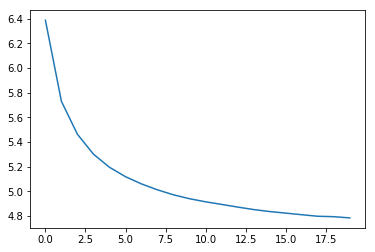

In [35]:
# plt.yscale('log')
plt.plot(history.history['loss'])

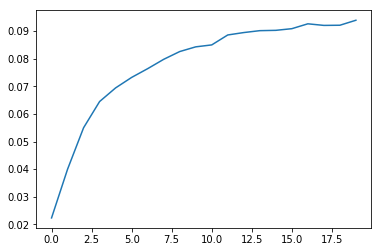

In [36]:
# plt.yscale('log')
plt.plot(history.history['accuracy'])

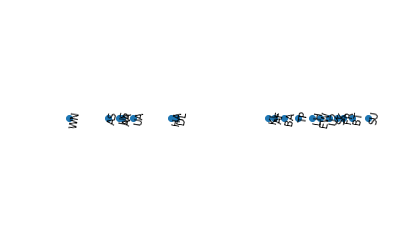

In [37]:
import numpy as np

embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)

# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, 0), rotation=80)

## Clustering in 2d

1d embedding vs size of airline
* find what is similar
* what is an outlier

In [0]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://www.tvlon.com/resources/airlinecodes.htm
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

airline_size = {
    'LH': 130, 'BA': 105, 'SK': 30, 'KL': 101, 'AF': 101, 'FR': 129, 'SU': 56, 'EW': 24, 'TP': 16, 'BT': 4, 'U2': 88, 'AA': 204, 'US': 204, 'UA': 158, 'WN': 164, 'DL': 192, 'AS': 46, 'HA': 12
}
sample_names = [airline_tokenizer.index_word[sample].upper() for sample in samples]
sample_sizes = [airline_size[name] * 1e6 for name in sample_names]

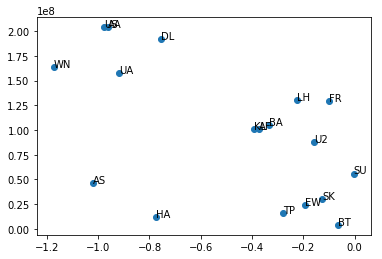

In [39]:
# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)
# plt.axis('off')

plt.scatter(embeddings_1d, sample_sizes)
for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
  plt.annotate(name, (x_pos,  y_pos))

In [40]:
from sklearn.preprocessing import StandardScaler

embeddings_1d_scaled = StandardScaler().fit_transform(embeddings_1d.reshape(-1, 1))
sizes_for_samples_scaled = StandardScaler().fit_transform(np.array(sample_sizes).reshape(-1, 1))
X = np.dstack((embeddings_1d_scaled.reshape(-1), sizes_for_samples_scaled.reshape(-1)))[0]
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[ 0.70318397,  0.48321195],
       [ 0.41612464,  0.10570261],
       [ 0.95606101, -1.0268254 ],
       [ 0.25293953,  0.04530112],
       [ 0.30989108,  0.04530112],
       [ 1.02468706,  0.46811158],
       [ 1.28140151, -0.63421569],
       [ 0.78085841, -1.11742764],
       [ 0.55718698, -1.23823063],
       [ 1.11611986, -1.41943512],
       [ 0.87295581, -0.15100374],
       [-1.24211731,  1.6006396 ],
       [-1.27967288,  1.6006396 ],
       [-1.1299887 ,  0.90602241],
       [-1.79171324,  0.99662466],
       [-0.6932001 ,  1.41943512],
       [-1.3927802 , -0.78521943],
       [-0.74193744, -1.29863213]])

In [53]:
%%time

from sklearn.cluster import DBSCAN

clf = DBSCAN(eps=0.5, min_samples=2)
clf.fit(X_scaled)
clusters = clf.labels_.astype(np.int)
clusters

CPU times: user 1.69 ms, sys: 65 µs, total: 1.76 ms
Wall time: 1.6 ms


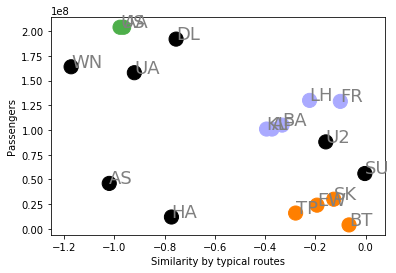

In [54]:
import matplotlib.pyplot as plt

from itertools import cycle, islice

# last color is black to properly display label -1 as noise (black)
colors = np.append(np.array(list(islice(cycle(['#AAAAFF', '#ff7f00', '#4daf4a',
                                 '#f781bf', '#a65628', '#984ea3',
                                 '#999999', '#e41a1c', '#dede00']),
                          int(max(clusters) + 1)))), ['#000000'])

# plt.figure(dpi=600)

plt.xlabel('Similarity by typical routes')
plt.ylabel('Passengers')

plt.scatter(embeddings_1d, sample_sizes, color=colors[clusters], s=200)
for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
  plt.annotate(name, (x_pos,  y_pos), fontsize=18, color='grey')


## Making results more stable

* when you visualize latent spaces they should not change much when re-training or fitting additional data points
* when working with autoencoders or embeddings there are two ways to make that happen
  1. save model, do not retrain from scratch and only fit new data points with low learning rate
  1. save output from embedding and keep new latent space similar by adding to the loss function

In [0]:
# save complete model
model.save('airline-embedding-v1.h5')
del model